In [11]:
import pyrootutils
root = pyrootutils.setup_root(".", pythonpath=True, cwd=True)

In [12]:
import pandas as pd
import numpy as np
import torch
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image, ImageOps
import os
from tqdm import tqdm
import rich
from collections import Counter
import matplotlib.pyplot as plt

In [13]:
from src.data.face_age_dataset import FaceAgeDataset

In [14]:
class cfg:
    img_size = (224, 224)
    max_age = 80
    val_size = 1600
    test_size = 1600
    max_imgs_per_class = 700
    oversample_with_augmentation = True

In [15]:
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)
transform = [transforms.Normalize(imagenet_mean, imagenet_std)]

ds = FaceAgeDataset(
    data_dir="data/",
    img_size=cfg.img_size,
    label_clipping=(1, cfg.max_age),
    normalize_labels=False,
    transform=transform,
)

In [16]:
x, y, idx = ds[0]
x.shape, y.shape, idx

(torch.Size([3, 224, 224]), torch.Size([1]), 0)

In [17]:
# create folders for new dataset
os.makedirs("data/face_age_dataset/train", exist_ok=True)
os.makedirs("data/face_age_dataset/val", exist_ok=True)
os.makedirs("data/face_age_dataset/test", exist_ok=True)

In [18]:
imgs_per_val_class = int(cfg.val_size / cfg.max_age)
imgs_per_test_class = int(cfg.test_size / cfg.max_age)

used_idxs = set()

### Generate validation set

In [19]:
class_counts_val = Counter()

for x, y, idx in tqdm(DataLoader(ds, shuffle=True)):
    idx = int(idx)
    y = int(y)
    count = class_counts_val[y]
    
    if count < imgs_per_val_class:
        class_counts_val[y] += 1
        used_idxs.add(idx)
        x = x.squeeze(0)
        torch.save(x, f"data/face_age_dataset/val/{idx}_age_{y}.pt")
        
print("Val imgs:", sum(class_counts_val.values()))

100%|██████████| 23708/23708 [00:19<00:00, 1207.00it/s]

Val imgs: 1600


### Generate test set

In [20]:
class_counts_test = Counter()

for x, y, idx in tqdm(DataLoader(ds, shuffle=True)):
    idx = int(idx)
    y = int(y)
    count = class_counts_test[y]
    
    if count < imgs_per_test_class and idx not in used_idxs:
        class_counts_test[y] += 1
        used_idxs.add(idx)
        x = x.squeeze(0)
        torch.save(x, f"data/face_age_dataset/test/{idx}_age_{y}.pt")
        
print("Test imgs:", sum(class_counts_test.values()))

 12%|█▏        | 2943/23708 [00:02<00:19, 1044.16it/s]


KeyboardInterrupt: 

### Generate train set

In [ ]:
class_counts_train = Counter()

for x, y, idx in tqdm(DataLoader(ds, shuffle=True)):
    idx = int(idx)
    y = int(y)
    count = class_counts_train[y]
    
    if count < cfg.max_imgs_per_class and idx not in used_idxs:
        class_counts_train[y] += 1
        x = x.squeeze(0)
        torch.save(x, f"data/face_age_dataset/train/{idx}_age_{y}.pt")

print("Train imgs:", sum(class_counts_train.values()))

100%|██████████| 23708/23708 [00:29<00:00, 808.57it/s]

Train imgs: 21173


Before augmentation:


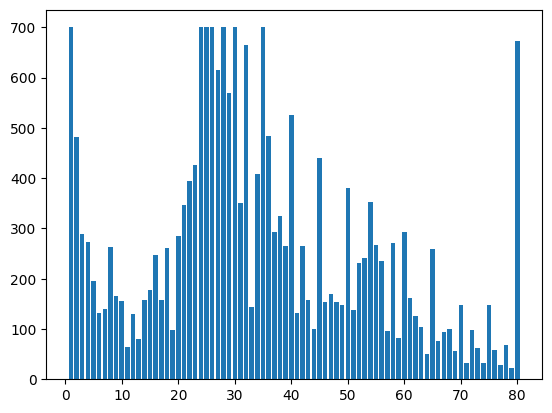

100%|██████████| 80/80 [06:28<00:00,  4.86s/it]

After augmentation:


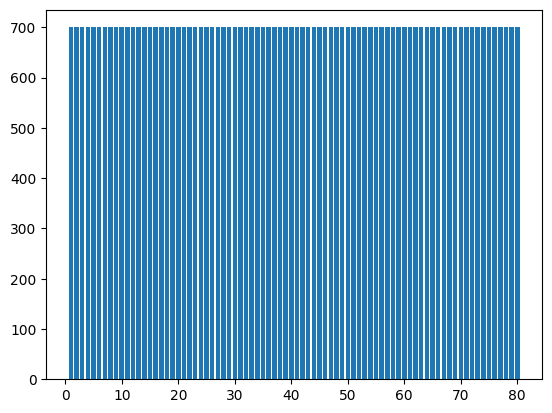

In [ ]:
print("Before augmentation:")
plt.bar(class_counts_train.keys(), class_counts_train.values())
plt.show()

transform_list = [
    transforms.RandomRotation(20),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5, fill=0),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
]
transform = transforms.Compose(transform_list)


if cfg.oversample_with_augmentation:
    os.makedirs("data/face_age_dataset/train_augmented", exist_ok=True)
    augmented_imgs_count = 0
    
    # iterate over labels
    for label in tqdm(range(1, cfg.max_age + 1)):
        
        # load all images for label
        img_paths = [x for x in os.listdir("data/face_age_dataset/train") if f"age_{label}.pt" in x]
        imgs = [torch.load(f"data/face_age_dataset/train/{x}") for x in img_paths]
        
        # augment images while there are less than max_imgs_per_class
        augmented_imgs = []
        while len(imgs) + len(augmented_imgs) < cfg.max_imgs_per_class:
            for img in imgs:
                
                if len(imgs) + len(augmented_imgs) >= cfg.max_imgs_per_class:
                    break
                
                augmented_imgs_count += 1
                class_counts_train[label] += 1
                augmented_imgs.append(transform(img))
                

        # for idx, img in enumerate(imgs):
        #     torch.save(img, f"data/face_age_dataset/train_augmented/{idx}_age_{label}.pt")
            
        for idx, img in enumerate(augmented_imgs):
            torch.save(img, f"data/face_age_dataset/train_augmented/augmented_{idx}_age_{label}.pt")
        

print("After augmentation:")
plt.bar(class_counts_train.keys(), class_counts_train.values())
plt.show()

In [ ]:
print(class_counts_train)
print(class_counts_val)
print(class_counts_test)

print(len(class_counts_train.keys()))
print(len(class_counts_val.keys()))
print(len(class_counts_test.keys()))

print("Train imgs:", sum(class_counts_train.values()))
print("Val imgs:", sum(class_counts_val.values()))
print("Test imgs:", sum(class_counts_test.values()))

Counter({1: 700, 80: 700, 63: 700, 20: 700, 28: 700, 32: 700, 30: 700, 73: 700, 56: 700, 13: 700, 25: 700, 50: 700, 79: 700, 26: 700, 33: 700, 23: 700, 8: 700, 16: 700, 35: 700, 54: 700, 27: 700, 36: 700, 60: 700, 45: 700, 55: 700, 37: 700, 31: 700, 9: 700, 10: 700, 24: 700, 65: 700, 47: 700, 43: 700, 46: 700, 2: 700, 18: 700, 3: 700, 41: 700, 40: 700, 67: 700, 42: 700, 72: 700, 4: 700, 22: 700, 29: 700, 53: 700, 21: 700, 34: 700, 5: 700, 75: 700, 52: 700, 15: 700, 66: 700, 68: 700, 39: 700, 58: 700, 12: 700, 57: 700, 38: 700, 49: 700, 61: 700, 69: 700, 17: 700, 76: 700, 19: 700, 71: 700, 14: 700, 6: 700, 59: 700, 51: 700, 44: 700, 78: 700, 62: 700, 77: 700, 48: 700, 7: 700, 70: 700, 11: 700, 74: 700, 64: 700})
Counter({28: 20, 25: 20, 21: 20, 26: 20, 1: 20, 30: 20, 63: 20, 18: 20, 40: 20, 45: 20, 36: 20, 80: 20, 44: 20, 65: 20, 32: 20, 4: 20, 52: 20, 22: 20, 64: 20, 38: 20, 29: 20, 20: 20, 27: 20, 5: 20, 37: 20, 39: 20, 9: 20, 16: 20, 58: 20, 24: 20, 33: 20, 3: 20, 12: 20, 70: 20, 62: